In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [91]:
df = pd.read_pickle('data/filtered_stocks_daily.pickle')
df = df['600330.SH']
df = df[::-1].reset_index(drop=True)

for i in range(1, 11):
    df['pre_change_' + str(i)] = df['change'].shift(i)

df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,...,pre_change_1,pre_change_2,pre_change_3,pre_change_4,pre_change_5,pre_change_6,pre_change_7,pre_change_8,pre_change_9,pre_change_10
0,600330.SH,20130118,5.59,5.67,5.52,5.62,5.59,0.03,0.54,62929.29,...,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04,0.13,-0.02,-0.02
1,600330.SH,20130121,5.61,5.65,5.54,5.60,5.62,-0.02,-0.36,50329.53,...,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04,0.13,-0.02
2,600330.SH,20130122,5.60,5.62,5.42,5.47,5.60,-0.13,-2.32,66996.79,...,-0.02,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04,0.13
3,600330.SH,20130123,5.41,5.50,5.32,5.40,5.47,-0.07,-1.28,50131.63,...,-0.13,-0.02,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04
4,600330.SH,20130124,5.42,5.55,5.31,5.39,5.40,-0.01,-0.19,77405.78,...,-0.07,-0.13,-0.02,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24


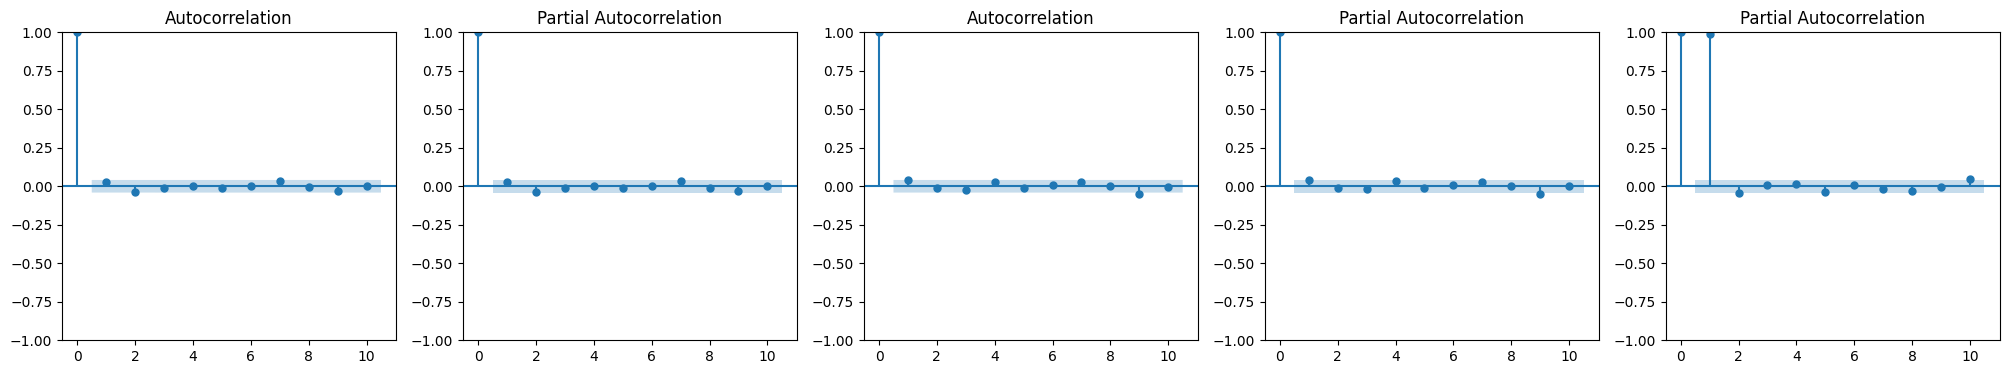

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(25, 4))
plot_acf(df['pct_chg'], lags=10, ax=ax1)
plot_pacf(df['pct_chg'], lags=10, ax=ax2)
plot_acf(df['change'], lags=10, ax=ax3)
plot_pacf(df['change'], lags=10, ax=ax4)
plot_pacf(df['close'], lags=10, ax=ax5)
plt.show()

In [75]:
df.filter(regex=("pre_change*")).head()

,pre_change_0,pre_change_1,pre_change_2,pre_change_3,pre_change_4,pre_change_5,pre_change_6,pre_change_7,pre_change_8,pre_change_9
0,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04,0.13,-0.02,-0.02
1,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04,0.13,-0.02
2,-0.02,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04,0.13
3,-0.13,-0.02,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24,-0.04
4,-0.07,-0.13,-0.02,0.03,-0.11,0.10,0.14,0.18,-0.29,0.24


In [92]:
# generate features

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(df.filter(regex=("pre_change*")), df['change'], random_state=0, shuffle=False, test_size=0.1)

scaler_1 = StandardScaler()
scaler_2 = StandardScaler()

X_train = scaler_1.fit_transform(np.array(X_train).reshape(-1,X_train.shape[1]))
y_train = scaler_2.fit_transform(np.array(y_train).reshape(-1,1))

X_test = scaler_1.transform(np.array(X_test).reshape(-1,X_test.shape[1]))
y_test = scaler_2.transform(np.array(y_test).reshape(-1,1))

# # X_train = train_df.drop(train_df.index[-1], axis=0)
# # X_test = train_df.iloc[train_df.index[-1]]
# # y_train = val_df.drop(val_df.index[-1], axis=0)
# # y_test = val_df.iloc[val_df.index[-1]]

# X_train = np.array(X_train).reshape(-1, 1)
# X_test = np.array(X_test).reshape(-1, 1)
# y_train = np.array(y_train).reshape(-1, 1)
# y_test = np.array(y_test).reshape(-1, 1)

In [129]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=10000,
    decay_rate=1e-6)

model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
# model.add(LSTM(1024, return_sequences=False))
model.add(Dense(256))
# model.add(Dense(64))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))


# model.add(Dense(32, input_shape=(X_train.shape[1], ), activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))

history = model.fit(X_train, y_train, batch_size=50, epochs=150)

Epoch 1/150
42/42 [==============================] - 5s 72ms/step - loss: 1.0406
Epoch 2/150
42/42 [==============================] - 3s 76ms/step - loss: 1.0056
Epoch 3/150
42/42 [==============================] - 3s 79ms/step - loss: 1.0009
Epoch 4/150
42/42 [==============================] - 3s 81ms/step - loss: 1.0021
Epoch 5/150
42/42 [==============================] - 3s 78ms/step - loss: 1.0006
Epoch 6/150
42/42 [==============================] - 5s 110ms/step - loss: 1.0009
Epoch 7/150
42/42 [==============================] - 4s 90ms/step - loss: 1.0004
Epoch 8/150
42/42 [==============================] - 5s 122ms/step - loss: 1.0027
Epoch 9/150
42/42 [==============================] - 3s 75ms/step - loss: 1.0055
Epoch 10/150
42/42 [==============================] - 5s 114ms/step - loss: 1.0040
Epoch 11/150
42/42 [==============================] - 5s 114ms/step - loss: 1.0017
Epoch 12/150
42/42 [==============================] - 3s 81ms/step - loss: 1.0003
Epoch 13/150
42/42 [=

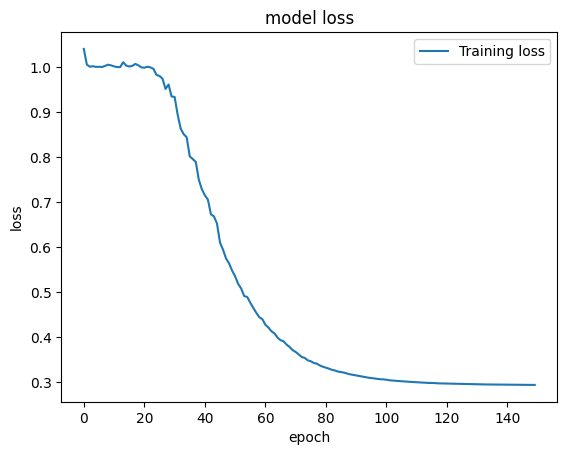

In [130]:
plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

8/8 [==============================] - 1s 66ms/step


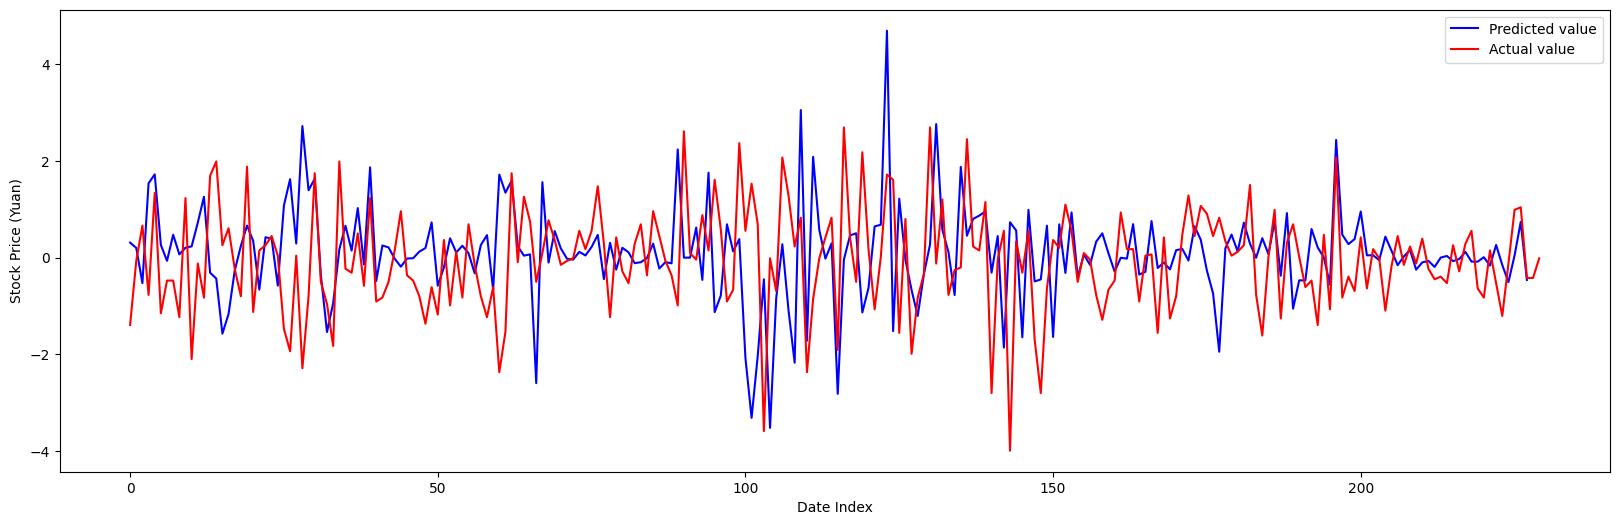

In [138]:
predictions = model.predict(X_test)

plt.figure(figsize=(20,6))

plt.plot(predictions[2:], color='blue', label='Predicted value')
plt.plot(y_test, color='red', label='Actual value')
plt.legend()
plt.xlabel('Date Index')
plt.ylabel('Stock Price (Yuan)')
plt.show()

In [119]:
res = []
curr_price_diff = list(X_test[0])

for i in range(15):
    pred = model.predict(np.array(curr_price_diff).reshape(-1,len(X_test[0])))
    res.append(pred.flatten()[-1])

    for i in range(len(curr_price_diff)-1):
      curr_price_diff[i+1] = curr_price_diff[i]

    curr_price_diff[0] = pred.flatten()[-1]




1/1 [==============================] - 0s 64ms/step


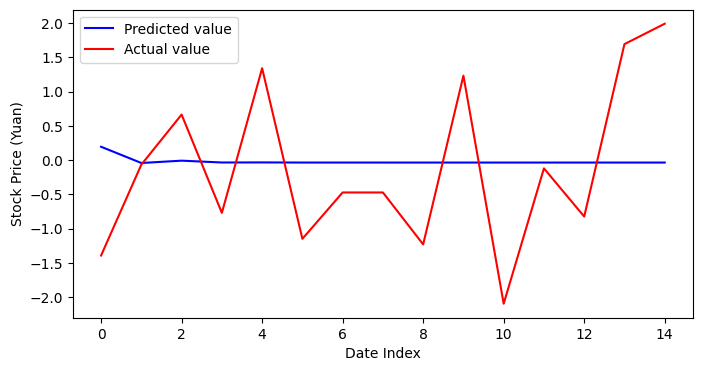

In [121]:
plt.figure(figsize=(8,4))

plt.plot(res, color='blue', label='Predicted value')
plt.plot(y_test[:15], color='red', label='Actual value')
plt.legend()
plt.xlabel('Date Index')
plt.ylabel('Stock Price (Yuan)')
plt.show()

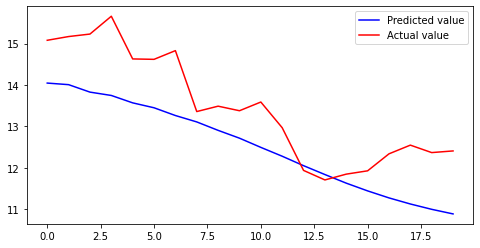

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(res, color='blue', label='Predicted value')
plt.plot(y_test[:20], color='red', label='Actual value')
plt.legend()
plt.show()

In [125]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
res = dummy_regr.predict(X_test)
mean_squared_error(y_test, res)

1.139742168467484

In [126]:
lstm_pred = model.predict(X_test)
mean_squared_error(lstm_pred, y_test)

8/8 [==============================] - 0s 16ms/step


2.2169450769901626

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
mean_squared_error(xgb_pred, y_test)

[21:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.3379407464788799

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbf = GradientBoostingRegressor(n_estimators=400, max_depth=5)
gbf.fit(X_train, y_train)
gbf_pred = gbf.predict(X_test).reshape(-1, 1)
mean_squared_error(gbf_pred, y_test)

0.358053255800311